# 00-Data Treatment


The data set available for this work may be grouped into two different categories:
- **Energy Consumption Data (ECD)**
    - Buildings energy consumption:
        - Civil
        - South Tower
    
    
- **Weather Conditions Data (WCD)**
    - outdoor weather temperature
    - relative humidity
    - solar radiation
    - ...

As natural, data gathered from sensors and electric meters, often called as **raw data**, includes incomplete, imprecise, and noisy values.
To proceed to the model development, it is mandatory to acknowledge and handle the uncertainty of it. 

To address that, in this notebook, were are going to perform four sequential steps:
1. Frequency preservation
2. Outliers analysis
3. Data Imputation Study
4. Imputation Strategies - Creation of different datasets

**NOTE:** The first step will not be shown, since it is just an hourly frequency preservation to keep the data set time continuity. Meaning that, every missing or repeating hour, was added or deleted, respectively, creating a missing value row if needed.


In [8]:
# Import packages
import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

**Import and Concatenate the data**

In [9]:
dt_2014 = pd.read_csv('Preprocessed_Data/_00_dt_2014.csv',index_col=[0],parse_dates=[0], header=0)
dt_2017_18 = pd.read_csv('Preprocessed_Data/_00_dt_2017_18.csv',index_col=[0],parse_dates=[0], header=0)

# Concatenate both dataframes
dt_2014.reset_index(inplace=True)
dt_2017_18.reset_index(inplace=True)

dt = pd.concat([dt_2014, dt_2017_18])
dt.set_index('timestamp', inplace=True)

# Drop the Buildings that are not going to be evaluated
dt = dt.drop(['central', 'north_tower'], 1)

**Check the dataframes**

In [10]:
dt.head()

,civil,south_tower,wt_temp,wt_tmpap,wt_hr,wt_max_windgust,wt_mean_windspd,wt_mean_pres,wt_mean_solarrad,wt_rain_day
timestamp,,,,,,,,,,
2014-01-01 01:00:00,65.99413,114.897996,12.6,10.5,88.3,7.3,3.4,1021.0,0.6,4.9
2014-01-01 02:00:00,66.20412,114.819072,12.9,10.3,87.3,7.8,4.0,1021.0,0.7,4.9
2014-01-01 03:00:00,67.27316,114.491295,13.1,10.2,86.2,8.6,4.6,1020.8,0.7,5.0
2014-01-01 04:00:00,65.53597,115.337955,13.2,10.0,85.9,9.3,4.9,1020.0,0.8,5.0
2014-01-01 05:00:00,68.03676,114.201319,13.2,10.2,85.2,8.6,4.6,1020.0,0.6,5.0


In [11]:
# Check some information about the data set
dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2014-01-01 01:00:00 to 2018-12-31 23:00:00
Data columns (total 10 columns):
civil               26276 non-null float64
south_tower         26276 non-null float64
wt_temp             23923 non-null float64
wt_tmpap            23923 non-null float64
wt_hr               23923 non-null float64
wt_max_windgust     23923 non-null float64
wt_mean_windspd     23923 non-null float64
wt_mean_pres        23923 non-null float64
wt_mean_solarrad    23923 non-null float64
wt_rain_day         23923 non-null float64
dtypes: float64(10)
memory usage: 2.2 MB


We can see that the dataframe - dt - has already some missing values:
- e.g. WCD has 23923 non-null values in 26280 rows.

But, lets first clean the **Outliers** and then deal with the **Missing values**.

### Creation of temporal Features

Not only to ease the analysis of outliers and data imputation but also because it is important for certain models, in time-series data, to provide input about the day, hour and month that a certain consumption took place.

In [12]:
def create_time_features(dt):
    # Create a column Date from index
    dt['date'] = dt.index
    pre = 't_'
    # Add 4 columns with year, month, day and hour
    dt[pre+'hour'] = dt['date'].dt.hour
    dt[pre+'month'] = dt['date'].dt.month
    dt[pre+'dayofweek'] = dt['date'].dt.weekday
    dt[pre+'year'] = dt['date'].dt.year
    
    dt = dt.drop(['date'], axis = 1)
    return dt

dt = create_time_features(dt)

## 1.1 Outliers analysis

An outlier is an abnormal data value that considerably diverges from the rest of the data points of the same feature. Their inclusion may affect negatively the predictive model accuracy. Although, in certain situations, an outlier may contain important information about a specific event or system behaviour. As a result of this ambiguity, a conservative **Z score above 3** was used. 
This analysis was applied only to **ECD** and can be summarized in the following steps:

1. Replace any zero by NaN, since it is not normal that an institutional building has no consumption for one hour;
2. Apply Z score, with a thershold of 3.5;
3. Visualization and decision of each selected outlier.

**Step 1** - Replace - zero energy consumptions by NaN

In [13]:
# Check the Zeros
print("Number of zeros per building\n")
print(dt.isin([0]).sum()[:2])

# Replace by NaN function
def zeros_to_nan(dt):
    building_cols = ['civil','south_tower']
    dt[building_cols] = dt[building_cols].replace(0, np.nan)
zeros_to_nan(dt)

print("\nAfter the replacement\n")
print(dt.isin([0]).sum()[:2])

Number of zeros per building

civil          153
south_tower     88
dtype: int64

After the replacement

civil          0
south_tower    0
dtype: int64


**Step 2 and Step 3** - Statistical Metric / Visualization / Replace by NaN if selected

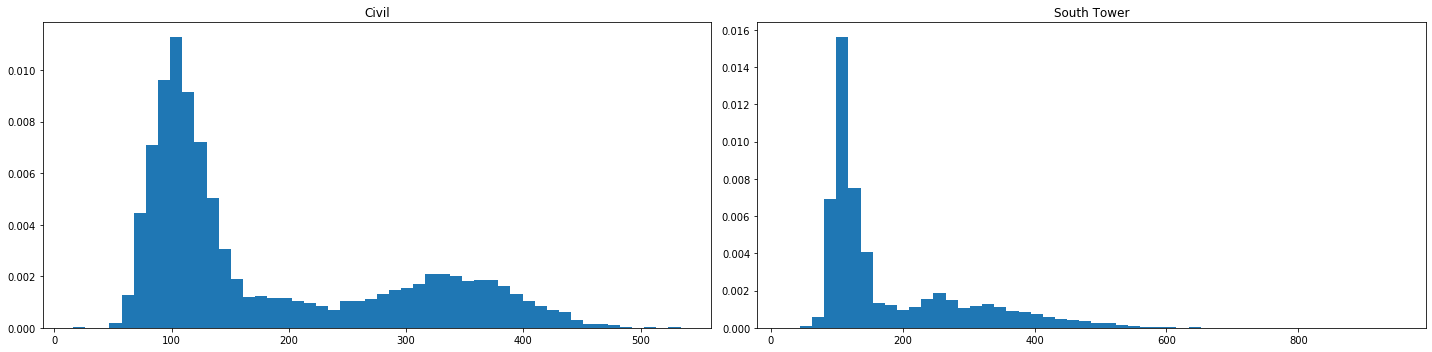

In [14]:
# Check histogram
def show_hist(data=dt):
    n_bins = 50
    fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    ax0.hist(data['civil'].values, n_bins, density=True, histtype='bar')
    ax0.set_title('Civil')

    ax1.hist(data['south_tower'].values, n_bins, density=True, histtype='bar')
    ax1.set_title('South Tower')

    fig.tight_layout()
    plt.show()
show_hist()

As it is possible to see, our consumption data does not have a normal distribution, because of that it may be misleading use z score to identify the outliers. 
To address that, after the application of the z score threshold, each outlier was visualized and removed if needed.

**NOTE:** The z-score is frequently used because according to the Central Limit Theorem, when the data are sufficiently numerous, tend to be normally distributed regardless of the underlying distribution.

In [15]:
# Outliers function
def outliers(feature, dt, threshold):
    '''
    INPUT: Feature, DataFrame, threshold
    
    Calculates the absolute z score
    Selects the values based on the threshold defined
    
    OUTPUT: DataFrame
    '''
    # Creation of a dataframe of outliers
    dt_outliers = dt[[feature, 't_hour']]
    # Calculation of the Z_score of each value
    dt_outliers['z_score_'+feature] = np.abs(((dt_outliers[feature] - dt_outliers[feature].mean())/dt_outliers[feature].std()))
    
    # Return the dataframe that has an absolute value higher than the threshold
    return dt_outliers.loc[dt_outliers['z_score_'+feature]>threshold]

# Show Outliers
def show_day(day, hour, z_score, count, n_outliers,feature):
    '''
    Visualization of each day
    Identification of the outlier
    '''
    
    data = dt[feature][day]

    x = ["%.2d" % i for i in range(24)]
    y = data.values
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    plt.plot(x, y, label = day)
    plt.xlim('00', '23')
    
    # Suppose outlier
    plt.axvline(x=hour, color='r', linestyle='--', label='Outlier'+ " | z_score = "+z_score)
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=20)
    plt.ylabel('Consumption (kWh)', fontsize=20)
    plt.xlabel('Hour', fontsize=20)
    plt.title(f'{count} of {n_outliers} Identified Outliers Checked', fontsize=30)
    plt.legend(loc=2, fontsize=20)
    plt.show()

# Function to call
def visual_decision_outliers(dt_outlier):
    '''
    INPUT: Outliers DataFrame (OUTPUT FROM FUNCTION OUTLIERS)
    
    Basically it grabs the dataframe and gives the opportunity 
    for the user to decide, which of the pre-selected outliers
    to remove from the original dataframe.
    
    OUTPUT: Str type, information of what happened
    
    '''
    # We need to restrict the number of visualizations for each day
    # with set or something
    from IPython.display import clear_output
    count = 1
    n_outliers = len(dt_outlier)
    lst_dates_off = []
    for date in dt_outlier.index:
        
        day = str(date).split(" ")[0]
        hour = str(date).split(" ")[1][:2]
        z_score = str(round(dt_outlier.loc[date, 'z_score_'+dt_outlier.columns[0]], 2))

        clear_output(wait=True)
        show_day(day, hour, z_score, count, n_outliers, dt_outlier.columns[0])
        
        count += 1
        # Input of the user
        is_hour_off = int(input("\nOutlier? (1=yes/0=no): "))       
        if is_hour_off:
            lst_dates_off.append(str(day)+" "+str(hour))
        else:
            continue
            
    #clear_output(wait=True)
    print('Dates selected to remove: ', lst_dates_off)
    if lst_dates_off == []:
        print('There is no outliers to remove!')
    else:
        dcs = int(input("\nAre you sure this is the outliers that you want to substitute by NaN (yes=1/no=0): "))
        if dcs == 1:
            for l in lst_dates_off:
                dt.loc[l, dt_outlier.columns[0]] = np.nan
            print('The outliers were removed')
        else:
            print('The outliers were not removed')

### 1.1.1 Civil

In [16]:
visual_decision_outliers(outliers('civil', dt, 3.5))

Dates selected to remove:  []
There is no outliers to remove!


### 1.1.2 South Tower

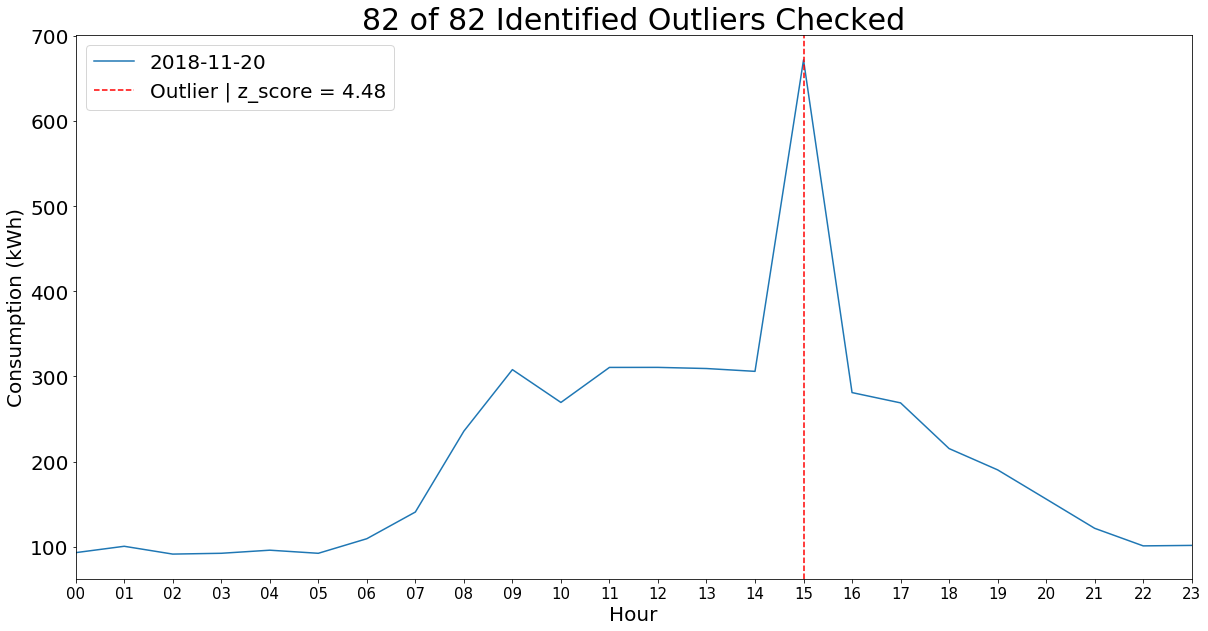


Outlier? (1=yes/0=no): 1
Dates selected to remove:  ['2017-03-22 18', '2018-03-07 13', '2018-09-17 17', '2018-11-20 15']

Are you sure this is the outliers that you want to substitute by NaN (yes=1/no=0): 1
The outliers were removed


In [17]:
visual_decision_outliers(outliers('south_tower', dt, 3.5))

The outliers previously identified were removed if it corresponds to a sudden consumption peak as it can be seen in the last figure from South Tower building, from 2018-11-20 at 15p.m..
Fortunately, Civil building hourly consumptions were always below the threshold defined.

## 1.2 Missing Values

As a consequence of the first steps, now the data set has a greater number of missing values than before it is mandatory to quantify and check their distribution per feature.

In [22]:
# Function use to visualize our missing data
def percentage_feature(dt):
    return dt.isna().mean()*100

def quantity_feature(dt):
    return dt.isna().sum()

def distribution(dt):
    return msno.matrix(dt, sparkline=False, figsize=(25, 15))

In [23]:
percentage_feature(dt)

civil               0.597412
south_tower         0.365297
wt_temp             8.968798
wt_tmpap            8.968798
wt_hr               8.968798
wt_max_windgust     8.968798
wt_mean_windspd     8.968798
wt_mean_pres        8.968798
wt_mean_solarrad    8.968798
wt_rain_day         8.968798
t_hour              0.000000
t_month             0.000000
t_dayofweek         0.000000
t_year              0.000000
dtype: float64

In [24]:
quantity_feature(dt)

civil                157
south_tower           96
wt_temp             2357
wt_tmpap            2357
wt_hr               2357
wt_max_windgust     2357
wt_mean_windspd     2357
wt_mean_pres        2357
wt_mean_solarrad    2357
wt_rain_day         2357
t_hour                 0
t_month                0
t_dayofweek            0
t_year                 0
dtype: int64

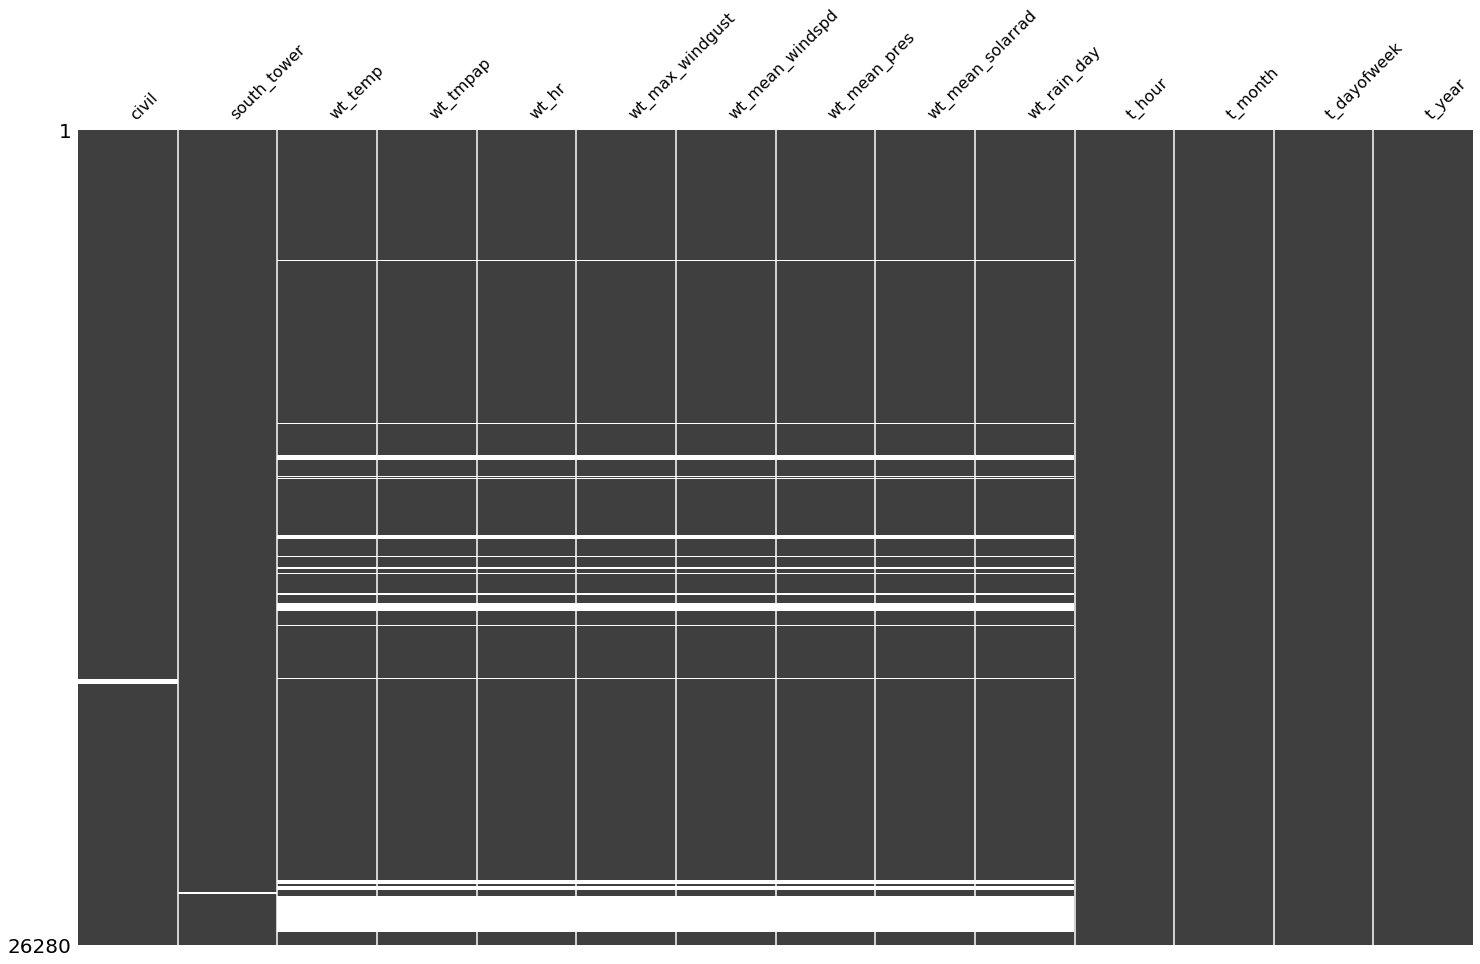

In [26]:
distribution(dt);

As it is possible to see, there is some missing data that should be take into account, specially in WCD, which has almost 2 months missing during 2018.


Since weather conditions are one major feature in building energy consumption, we will try to address this problem through a **data imputation study**, that may be found in the next notebook. 

To ease the data imputation study three new columns were created. Each column record can be 0 or 1, being the latter when there is a missing value of the correspondent feature. The features used were each of buildings consumption (civil and south_tower) and weather conditions.

In [27]:
# Creation of a missing column for weather and building missing values
# For each building it will be created a missing column, so the evaluation is not performed in the building imputate values
def missing_colgen(dt):
    feature_lst = ['civil', 'south_tower', 'wt_temp']
    for feature in feature_lst:           
        null_idx = dt[feature].isnull()
        
        if feature == 'wt_temp':
            feature = feature[:2]
            
        dt['miss_'+feature] = np.where(null_idx,1,0)
    return dt
dt = missing_colgen(dt)

In [28]:
dt.head()

,civil,south_tower,wt_temp,wt_tmpap,wt_hr,wt_max_windgust,wt_mean_windspd,wt_mean_pres,wt_mean_solarrad,wt_rain_day,t_hour,t_month,t_dayofweek,t_year,miss_civil,miss_south_tower,miss_wt
timestamp,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,65.99413,114.897996,12.6,10.5,88.3,7.3,3.4,1021.0,0.6,4.9,1,1,2,2014,0,0,0
2014-01-01 02:00:00,66.20412,114.819072,12.9,10.3,87.3,7.8,4.0,1021.0,0.7,4.9,2,1,2,2014,0,0,0
2014-01-01 03:00:00,67.27316,114.491295,13.1,10.2,86.2,8.6,4.6,1020.8,0.7,5.0,3,1,2,2014,0,0,0
2014-01-01 04:00:00,65.53597,115.337955,13.2,10.0,85.9,9.3,4.9,1020.0,0.8,5.0,4,1,2,2014,0,0,0
2014-01-01 05:00:00,68.03676,114.201319,13.2,10.2,85.2,8.6,4.6,1020.0,0.6,5.0,5,1,2,2014,0,0,0


In [29]:
dt.to_csv('Preprocessed_Data/_01_dt_00.csv')